# Implementing SGD from scratch

The equation for the gradient update in SGD is $w^{new}=w^{old}+\eta (y_{i}-x_{i}'w^{old})x_{i}$, source: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Extensions_and_variants

Running closed-form solution...
w: [ 0.48545013 -1.99831363] true w: [0.5, -2] diff: 0.0002145426024416703
MSE: 0.6602361244034094
Running SGD solution...
max_epochs reached without convergence


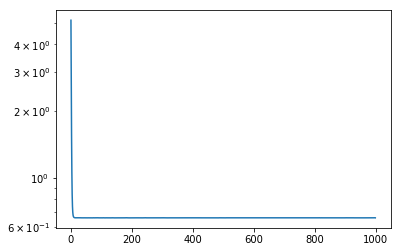

w: [ 0.46286258 -1.99021377] true w: [0.5, -2] diff: 0.0014749581787689586
MSE: 0.6611316038490116


In [26]:
import numpy as np, os, sys
import matplotlib.pyplot as plt
%matplotlib inline

def random_split(x, y, numtr):
    inds = np.arange(y.size)
    np.random.shuffle(inds)
    xtr = x[inds[0:numtr], :]
    ytr = y[inds[0:numtr]]
    xv = x[inds[numtr:], :]
    yv = y[inds[numtr:]]
    return xtr, ytr, xv, yv

def generate_1d_data(numtotal):
    w1 = 0.5
    w2 = -2
    xtr, ytr = generate_2d_data(w1=w1, w2=w2, epsilon=0.8, num=int(numtotal)) #numtotal
    xv, yv = generate_2d_data(w1=w1, w2=w2, epsilon=0.8, num=3000) #fix 3k test samples
    return xtr, ytr, xv, yv, w1, w2

def generate_1d_data2(numtotal):
    w1 = 0.5
    w2 = -2
    xtr, ytr = generate_2d_data(w1=w1, w2=w2, epsilon=0.8, num=int(0.7 * numtotal)) #70% of numtotal
    xv, yv = generate_2d_data(w1=w1, w2=w2, epsilon=0.8, num=int(0.3 * numtotal)) #30 % of numtotal
    return xtr, ytr, xv, yv, w1, w2

def generate_2d_data(w1, w2, epsilon, num):
    x = np.random.normal(size=(num, 2))
    y = x[:, 0] * w1 + x[:, 1] * w2 + epsilon * np.random.normal(size=(num))
    return x, y

def linreg_train(xtr, ytr, C):
    mat = np.linalg.inv(np.dot(xtr.T, xtr) + C * np.eye(xtr.shape[1]))
    w = np.dot(mat, np.dot(xtr.T, ytr))
    return w

def get_mse(ypred, ytrue):
    error = np.mean((ypred - ytrue)**2)
    return error

def get_validation_loss(w, xv, yv):
    ypred = np.dot(xv, w)
    error = get_mse(ypred, yv) 
    return error

def compute_gradient_single(w, x, y, C):
    g0 = 2 * np.dot((np.dot(w[0], x[0]) - y), x[0])
    g1 = 2 * np.dot((np.dot(w[1], x[1]) - y), x[1])
    return np.array([g0, g1])

def compute_gradient_minibatch(w, xb, yb, C):
    num_samples = xb.shape[0]
    grad = np.zeros(2)
    for i in range(num_samples):
        grad += 1. / float(num_samples) * compute_gradient_single(w, xb[i, :], yb[i], C)
    return grad       

def train_sgd(xtr, ytr, C, learning_rate, batch_size, max_epochs, threshold, xv, yv):
    # randomly initialize w, close to zero but not equal to zero
    w = np.random.normal(size=2)
    prev_loss = get_validation_loss(w, xv, yv) 
    conv = False
    losses = []
    
    for epoch_num in range(max_epochs):
        inds = np.arange(xtr.shape[0])
        # the order of samples should be randomized in every epoch                     
        # get a random order of indices that are used to sample minibatches 
        np.random.shuffle(inds)
        num_batches = int(xtr.shape[0] // batch_size)

        for batch_num in range(num_batches):
            start_index = batch_num * batch_size
            end_index = start_index + batch_size
            batch_indices = inds[start_index : end_index]
            batch_grad = compute_gradient_minibatch(w, xtr[batch_indices],  ytr[batch_indices], C)
            w = w - learning_rate * batch_grad
            
        # get validation loss with your newly updated parameters
        loss = get_validation_loss(w, xv, yv)
        losses.append(loss)
        # stop if loss change between old and current epoch is too small
        # and update value of prev_loss
        if (prev_loss - loss < threshold):
            conv = True
            
    if not conv:
        print('max_epochs reached without convergence')
        
    plot_loss(range(max_epochs), losses)
    return w

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.yscale('log')
    plt.show()    

def run1(xtr, ytr, xv, yv, w1, w2, C):
    print("Running closed-form solution...")
    w = linreg_train(xtr, ytr, C=C) # 0.1
    wtrue = np.asarray([w1, w2])
    print('w:', w, 'true w:', [w1, w2], 'diff:', np.dot((w - wtrue).T, w - wtrue))
    ypred = np.dot(xv, w)
    e = get_mse(ypred, yv)
    print('MSE:', e)
    return e, np.dot((w - wtrue).T, w - wtrue)

def run2(xtr, ytr, xv, yv, w1, w2, C):
    print("Running SGD solution...")
    learning_rate = 0.01
    batch_size = 100
    max_epochs = 1000 
    threshold = 0.0001
    w = train_sgd(xtr, ytr, C, learning_rate, batch_size, max_epochs, threshold, xv, yv)
    wtrue = np.asarray([w1, w2])
    print('w:', w, 'true w:', [w1, w2], 'diff:', np.dot((w-wtrue).T, w-wtrue))
    ypred = np.dot(xv, w)
    e = get_mse(ypred, yv)
    print('MSE:', e)
    return e, np.dot((w - wtrue).T, w - wtrue)

if __name__=='__main__':
    xtr, ytr, xv, yv, w1, w2 = generate_1d_data2(3000)    
    run1(xtr, ytr, xv, yv, w1, w2, 1e-3)
    run2(xtr, ytr, xv, yv, w1, w2, 1e-3)